In [1]:
# !pip3 install kafka-python==1.4.7 streamz==0.5.2 --user

In [2]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import waterhealer as wh
from waterhealer import Stream
import json
import time

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [5]:
def json_loads(rows):
    results = []
    for row in rows:
        results.append(json.loads(row))
        
    return results

def increment_left(rows):
    results = []
    for row in rows:
        row = row.copy()
        time.sleep(1)
        row['left'] = row['data'] + 1
        results.append(row)
    return results

def increment_right(rows):
    results = []
    for row in rows:
        row = row.copy()
        time.sleep(1)
        row['right'] = row['data'] + 1
        results.append(row)
    return results

def combine(tuples):
    
    left, right = tuples
    results = []
    for i in range(len(left)):
        time.sleep(1)
        results.append(left[i]['left'] + right[i]['right'])
        
    return results

In [6]:
source = Stream()
partition = source.scatter().partition_time(5, checkpoint = True)
s = partition.map(json_loads, checkpoint = True)
left = s.map(increment_left, checkpoint = True)
right = s.map(increment_right, checkpoint = True)
left.zip(right).map(combine, checkpoint = True).buffer(8).gather()

Output()

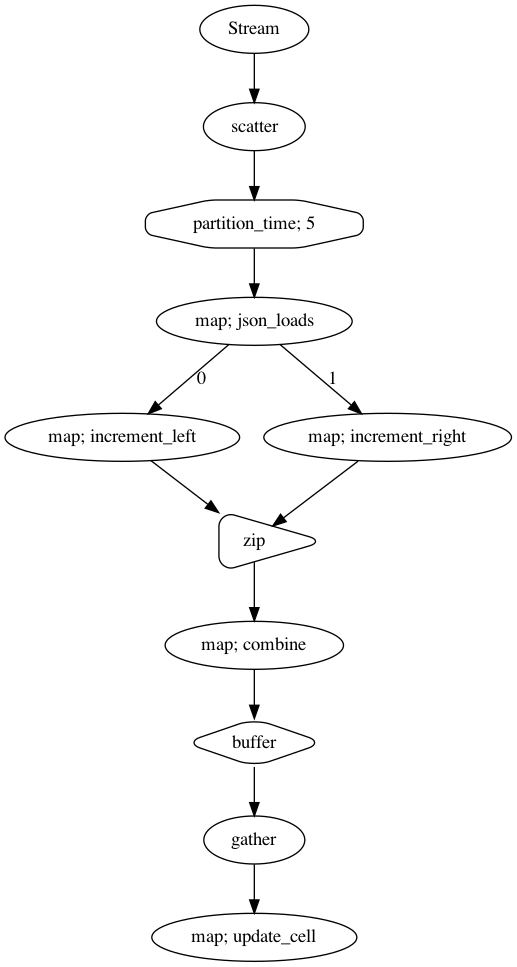

In [7]:
source.visualize()

In [8]:
for i in range(10):
    data = {'i': i, 'data': i + 1}
    source.emit(json.dumps(data))
    time.sleep(0.1)

In [9]:
%%time

source.wait()

CPU times: user 1.95 s, sys: 362 ms, total: 2.32 s
Wall time: 23.7 s


In [10]:
source.checkpoint

{'Stream.scatter.partition_time': ['{"i": 0, "data": 1}',
  '{"i": 1, "data": 2}',
  '{"i": 2, "data": 3}',
  '{"i": 3, "data": 4}',
  '{"i": 4, "data": 5}',
  '{"i": 5, "data": 6}',
  '{"i": 6, "data": 7}',
  '{"i": 7, "data": 8}',
  '{"i": 8, "data": 9}',
  '{"i": 9, "data": 10}'],
 'Stream.scatter.partition_time.map.json_loads': [{'i': 0, 'data': 1},
  {'i': 1, 'data': 2},
  {'i': 2, 'data': 3},
  {'i': 3, 'data': 4},
  {'i': 4, 'data': 5},
  {'i': 5, 'data': 6},
  {'i': 6, 'data': 7},
  {'i': 7, 'data': 8},
  {'i': 8, 'data': 9},
  {'i': 9, 'data': 10}],
 'Stream.scatter.partition_time.map.json_loads.map.increment_left': [{'i': 0,
   'data': 1,
   'left': 2},
  {'i': 1, 'data': 2, 'left': 3},
  {'i': 2, 'data': 3, 'left': 4},
  {'i': 3, 'data': 4, 'left': 5},
  {'i': 4, 'data': 5, 'left': 6},
  {'i': 5, 'data': 6, 'left': 7},
  {'i': 6, 'data': 7, 'left': 8},
  {'i': 7, 'data': 8, 'left': 9},
  {'i': 8, 'data': 9, 'left': 10},
  {'i': 9, 'data': 10, 'left': 11}],
 'Stream.scatter.p